In [1]:
!wget https://raw.githubusercontent.com/summitgao/DRCNN/master/preclassify.py

--2021-04-07 13:07:38--  https://raw.githubusercontent.com/summitgao/DRCNN/master/preclassify.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5660 (5.5K) [text/plain]
Saving to: ‘preclassify.py’

preclassify.py      100%[===================>]   5.53K  --.-KB/s    in 0s      

2021-04-07 13:07:38 (46.3 MB/s) - ‘preclassify.py’ saved [5660/5660]



解压数据集到当前环境

In [2]:
!cp -r /content/drive/My\ Drive/Change\ Detection/sar_pic.zip ./  #将google云盘中的数据集压缩文件拷贝到当前运行环境
!unzip sar_pic.zip  #将数据集压缩文件解压

Archive:  sar_pic.zip
   creating: sar_pic/
  inflating: sar_pic/beijing_1.bmp   
  inflating: sar_pic/beijing_2.bmp   
  inflating: sar_pic/beijing_gt.bmp  
  inflating: sar_pic/bern_1.bmp      
  inflating: sar_pic/bern_2.bmp      
  inflating: sar_pic/bern_gt.bmp     
  inflating: sar_pic/Farmland_1.bmp  
  inflating: sar_pic/Farmland_2.bmp  
  inflating: sar_pic/Farmland_gt.bmp  
  inflating: sar_pic/ice_part1_1.bmp  
  inflating: sar_pic/ice_part1_2.bmp  
  inflating: sar_pic/ice_part1_gt.bmp  
  inflating: sar_pic/ice_part1_gt.png  
  inflating: sar_pic/ice_part2_1.bmp  
  inflating: sar_pic/ice_part2_2.bmp  
  inflating: sar_pic/ice_part2_gt.bmp  
  inflating: sar_pic/italyflood_1.bmp  
  inflating: sar_pic/italyflood_2.bmp  
  inflating: sar_pic/italyflood_gt.bmp  
  inflating: sar_pic/ottawa_1.bmp    
  inflating: sar_pic/ottawa_2.bmp    
  inflating: sar_pic/ottawa_gt.bmp   
  inflating: sar_pic/san_1.bmp       
  inflating: sar_pic/san_2.bmp       
  inflating: sar_pic/san_g

导包

In [20]:
from skimage import io, measure
import numpy as np
from preclassify import dicomp, hcluster
import random
from collections import  Counter
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

超参设置

In [21]:
# 获取图片路径（包括原图1，原图2和人工标注差异图gt）
im1_path  = 'sar_pic/ottawa_1.bmp'
im2_path  = 'sar_pic/ottawa_2.bmp'
imgt_path = 'sar_pic/ottawa_gt.bmp'

# 用于训练的每个patch大小
patch_size3 = 3
patch_size5 = 5
patch_size7 = 7
patch_size9 = 9
patch_size = 31
# 设置训练集样本数
train_len = 20000
# 未改变和改变的训练集样本数
# 按比例选取
label_1_train_len = 17600

定义各类方法

In [22]:
# padding操作
def image_padding(data,r):
    if len(data.shape)==3:
        data_new=np.lib.pad(data,((r,r),(r,r),(0,0)),'constant',constant_values=0)
        return data_new
    if len(data.shape)==2:
        data_new=np.lib.pad(data,r,'constant',constant_values=0)
        return data_new

# 生成自然数数组并打乱
def arr(length):
  arr=np.arange(length-1)
  random.shuffle(arr)
  return arr

# 制作训练集
# 在每个像素周围提取 patch ，然后创建成符合 pytorch 处理的格式
def createTrainingCubes(X, y, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    # 把类别 uncertainty 的像素忽略
    ele_num1 = np.sum(y==1)
    ele_num2 = np.sum(y==2)
    # num1和num2的比例决定1、2随机选取样本的比例
    patchesData_1 = np.zeros( (ele_num1, patch_size, patch_size, X.shape[2]) )
    patchesLabels_1 = np.zeros(ele_num1)
    print(ele_num1)
    print(ele_num2)
    patchesData_2 = np.zeros((ele_num2, patch_size, patch_size, X.shape[2]))
    patchesLabels_2 = np.zeros(ele_num2)

    patchIndex_1 = 0
    patchIndex_2 = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            # 把类别 uncertainty 的像素忽略
            if y[r-margin, c-margin] == 1 :
                patch_1 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_1[patchIndex_1, :, :, :] = patch_1
                patchesLabels_1[patchIndex_1] = y[r-margin, c-margin]
                patchIndex_1 = patchIndex_1 + 1
            elif y[r-margin, c-margin] == 2 :
                patch_2 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_2[patchIndex_2, :, :, :] = patch_2
                patchesLabels_2[patchIndex_2] = y[r-margin, c-margin]
                patchIndex_2 = patchIndex_2 + 1
    patchesLabels_1 = patchesLabels_1-1
    patchesLabels_2 = patchesLabels_2-1

    arr_1=arr(len(patchesData_1))
    arr_2=arr(len(patchesData_2))
  
    pdata=np.zeros((train_len, patch_size, patch_size, X.shape[2]))
    plabels = np.zeros(train_len)
    #标签为1和2的按比例选取
    for i in range(label_1_train_len):
      pdata[i,:,:,:]=patchesData_1[arr_1[i],:,:,:]
      plabels[i]=patchesLabels_1[arr_1[i]]
    for j in range(label_1_train_len,train_len):
      pdata[j,:,:,:]=patchesData_2[arr_2[j-train_len//2],:,:,:]
      plabels[j]=patchesLabels_2[arr_2[j-train_len//2]]
    print(Counter(plabels))
    return pdata, plabels

# 制作测试集
def createTestingCubes(X, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    patchesData = np.zeros( (X.shape[0]*X.shape[1], patch_size, patch_size, X.shape[2]) )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchIndex = patchIndex + 1
    return patchesData

def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    num = res.max()
    for i in range(1, num+1):
        idy, idx = np.where(res==i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

def evaluate(gtImg, tstImg):
    gtImg[np.where(gtImg>128)] = 255
    gtImg[np.where(gtImg<128)] = 0
    tstImg[np.where(tstImg>128)] = 255
    tstImg[np.where(tstImg<128)] = 0
    [ylen, xlen] = gtImg.shape
    FA = 0
    MA = 0

    for j in range(0,ylen):
        for i in range(0,xlen):
            if gtImg[j,i]==0 and tstImg[j,i]!=0 :
                FA = FA+1
            if gtImg[j,i]!=0 and tstImg[j,i]==0 :
                MA = MA+1
  
    OE = FA+MA
    PCC = 1-OE/(ylen*xlen)
    print(' Change detection results ==>')
    print(' ... ... FA:  ', FA)
    print(' ... ... MA:  ', MA)
    print(' ... ... OE:  ', OE)
    print(' ... ... PCC: ', format(PCC*100, '.2f'))

读取图片（包括原图1，原图2和人工标注差异图gt）

In [23]:
im1 = io.imread(im1_path)[:,:,0].astype(np.float32)
im2 = io.imread(im2_path)[:,:,0].astype(np.float32)
im_gt = io.imread(imgt_path)[:,:,0].astype(np.float32)
print(im1.shape)

(350, 290)


计算差分图

In [24]:
im_di = dicomp(im1, im2)
ylen, xlen = im_di.shape
pix_vec = im_di.reshape([ylen*xlen, 1])

分析差分图之 使用 “hiearchical FCM 聚类方法” 进行预分类

In [25]:
# 将高概率 未改变 的像素的标签设为 1
# 将高概率 改变 的像素的标签设为 2
# 将 不确定 的像素的标签设为1.5
preclassify_lab = hcluster(pix_vec, im_di)
print('... ... hiearchical clustering finished !!!')

... ... 1st round clustering ... ...
... ... 2nd round clustering ... ...
... ... hiearchical clustering finished !!!


制作训练集和测试集

In [26]:
# 将原图1、原图2和差分图放到一个3维数组里
mdata = np.zeros([im1.shape[0], im1.shape[1], 3], dtype=np.float32)
mdata[:,:,0] = im1
mdata[:,:,1] = im2
mdata[:,:,2] = im_di
mlabel = preclassify_lab

# 制作训练集
x_train3, y_train3 = createTrainingCubes(mdata, mlabel, patch_size3)
x_train5, y_train5 = createTrainingCubes(mdata, mlabel, patch_size5)
x_train7, y_train7 = createTrainingCubes(mdata, mlabel, patch_size7)
x_train9, y_train9 = createTrainingCubes(mdata, mlabel, patch_size9)
x_train3 = x_train3.transpose(0, 3, 1, 2)
x_train5 = x_train5.transpose(0, 3, 1, 2)
x_train7 = x_train7.transpose(0, 3, 1, 2)
x_train9 = x_train9.transpose(0, 3, 1, 2)
print('... x train3 shape: ', x_train3.shape)
print('... y train3 shape: ', y_train3.shape)
print('... x train5 shape: ', x_train5.shape)
print('... y train5 shape: ', y_train5.shape)
print('... x train7 shape: ', x_train7.shape)
print('... y train7 shape: ', y_train7.shape)
print('... x train9 shape: ', x_train9.shape)
print('... y train9 shape: ', y_train9.shape)

# 制作测试集
x_test = createTestingCubes(mdata, patch_size)
x_test = x_test.transpose(0, 3, 1, 2)
print('... x test shape: ', x_test.shape)

82796
13232
Counter({0.0: 17600, 1.0: 2400})
82796
13232
Counter({0.0: 17600, 1.0: 2400})
82796
13232
Counter({0.0: 17600, 1.0: 2400})
82796
13232
Counter({0.0: 17600, 1.0: 2400})
... x train3 shape:  (20000, 3, 3, 3)
... y train3 shape:  (20000,)
... x train5 shape:  (20000, 3, 5, 5)
... y train5 shape:  (20000,)
... x train7 shape:  (20000, 3, 7, 7)
... y train7 shape:  (20000,)
... x train9 shape:  (20000, 3, 9, 9)
... y train9 shape:  (20000,)
... x test shape:  (101500, 3, 31, 31)


将不同大小的patch融合起来

In [27]:
from torchvision import transforms

transform = transforms.Resize((patch_size, patch_size),interpolation=2)

x_data3 = torch.FloatTensor(x_train3)
x_data3 = transform(x_data3)

x_data5 = torch.FloatTensor(x_train5)
x_data5 = transform(x_data5)

x_data7 = torch.FloatTensor(x_train7)
x_data7 = transform(x_data7)

x_data9 = torch.FloatTensor(x_train9)
x_data9 = transform(x_data9)

x_data = x_data3 + x_data5 + x_data7 + x_data9
y_data = torch.LongTensor(y_train3)

print(x_data3.shape)
print(x_data.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([20000, 3, 31, 31])
torch.Size([20000, 3, 31, 31])


定义读取数据集的类

In [28]:
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = x_train3.shape[0]
        self.x_data = x_data
        self.y_data = y_data
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
# trainset = trainset3 + trainset5 + trainset7 + trainset9
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=8, shuffle=True, num_workers=2)

定义网络模型

In [29]:
class PatchNet(nn.Module):
  def __init__(self):
    super(PatchNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=0, bias=False) 
    self.bn1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6, 24, kernel_size=3, stride=1, padding=0, bias=False) 
    self.bn2 = nn.BatchNorm2d(24)
    self.conv3 = nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=0, bias=False) 
    self.bn3 = nn.BatchNorm2d(48)
    self.max_pool = nn.MaxPool2d(kernel_size=2) 

    self.avg_pool1_1 = nn.AvgPool2d(kernel_size=2) 
    self.avg_pool1_2 = nn.AvgPool2d(kernel_size=4)
    self.avg_pool1_3 = nn.AvgPool2d(kernel_size=8)
    self.conv_middle = nn.Conv2d(48, 16, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn_middle = nn.BatchNorm2d(16)

    self.conv_final1 = nn.Conv2d(96, 16, kernel_size=3, stride=1, padding=0, bias=False) 
    self.bn_final1 = nn.BatchNorm2d(16)
    self.conv_final2 = nn.Conv2d(16, 6, kernel_size=1, stride=1, padding=0, bias=True) 
    self.linear1 = nn.Linear(600, 10) 
    self.linear2 = nn.Linear(10, 2)

  def forward(self, x):
    ori_out = F.relu(self.bn1(self.conv1(x)))
    ori_out = F.relu(self.bn2(self.conv2(ori_out)))
    ori_out = F.relu(self.bn3(self.conv3(ori_out)))
    ori_out = self.max_pool(ori_out)

    maxpool_feature = ori_out
    ori_out_1 = F.interpolate(F.relu(self.bn_middle(self.conv_middle(self.avg_pool1_1(ori_out)))), maxpool_feature.size()[2:])  #interpolate是上采样操作
    ori_out_2 = F.interpolate(F.relu(self.bn_middle(self.conv_middle(self.avg_pool1_2(ori_out)))), maxpool_feature.size()[2:])
    ori_out_3 = F.interpolate(F.relu(self.bn_middle(self.conv_middle(self.avg_pool1_3(ori_out)))), maxpool_feature.size()[2:])
    out = [maxpool_feature, ori_out_1, ori_out_2, ori_out_3]
    out = torch.cat(out, 1)

    out = self.conv_final1(out)
    out = self.bn_final1(out)
    out = self.conv_final2(out)
    out = out.view(out.size(0), -1)
    out = self.linear1(out)
    out = self.linear2(out)

    return out

训练

In [30]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = PatchNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
net.train()

# 开始训练
total_loss = 0
for epoch in range(1):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]  [loss avg: %.4f]  [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
print('Finished Training')

[Epoch: 1]  [loss avg: 92.7480]  [current loss: 0.0004]
Finished Training


测试

... ... row 50  handling ... ...
... ... row 100  handling ... ...
... ... row 150  handling ... ...
... ... row 200  handling ... ...
... ... row 250  handling ... ...
... ... row 300  handling ... ...
... ... row 350  handling ... ...
 Change detection results ==>
 ... ... FA:   40
 ... ... MA:   3276
 ... ... OE:   3316
 ... ... PCC:  96.73


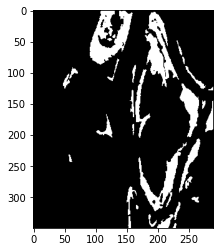

In [31]:
# 逐像素预测类别
net.eval()
outputs = np.zeros( (ylen, xlen) )

for i in range(ylen):
    for j in range(xlen):
        if preclassify_lab[i, j] != 1.5 :
            outputs[i, j] = preclassify_lab[i, j]
        else:
            img_patch = x_test[i*xlen+j, :, :, :]
            img_patch = img_patch.reshape(1, img_patch.shape[0], img_patch.shape[1], img_patch.shape[2])
            img_patch = torch.FloatTensor(img_patch).to(device)
            prediction = net(img_patch)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i, j] = prediction+1
    if (i+1) % 50 == 0:
        print('... ... row', i+1, ' handling ... ...')

outputs = outputs-1

plt.imshow(outputs, 'gray')

res = outputs*255
res = postprocess(res)
evaluate(im_gt, res)
plt.imshow(res, 'gray') 